#Celab 이미지를 학습시켜 얼굴이미지 생성하기

In [1]:
import h5py

In [2]:
import numpy
import matplotlib.pyplot as plt
import zipfile
import imageio
import os

import torch
import torch.nn as nn
from torch.utils.data import Dataset

import h5py
import pandas, numpy, random
import matplotlib.pyplot as plt

#cuda setting

In [3]:
if torch.cuda.is_available():
  torch.set_default_tensor_type(torch.cuda.FloatTensor)
  print("using cuda:", torch.cuda.get_device_name(0))
  pass

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

using cuda: Tesla T4


device(type='cuda')

#Function

In [4]:
def generate_random_image(size):
    random_data = torch.rand(size)
    return random_data


def generate_random_seed(size):
    random_data = torch.randn(size)
    return random_data

In [5]:
class View(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape,

    def forward(self, x):
        return x.view(*self.shape)

In [6]:
def crop_centre(img, new_width, new_height):
    height, width, _ = img.shape
    startx = width//2 - new_width//2
    starty = height//2 - new_height//2
    return img[  starty:starty + new_height, startx:startx + new_width, :]

## Dataset class

In [7]:
class CelabDataset(Dataset):

    def __init__(self, file):
        self.file_object = h5py.File(file, 'r')
        self.dataset = self.file_object['img_align_celeba']

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index) :
        #hy5y 형태의 경우 IndexError가 아닌 다른 오류가 발생
        if (index >= len(self.dataset)):
            raise IndexError()
        img = numpy.array(self.dataset[str(index)+ '.jpg'])
        img = crop_centre(img, 128, 128)

        #기존 numpy 행렬은 (h ,w , c) 형태로 되어있어서 permute로 순서 변경
        #view를 통해서 batch에 해당되는 부분 1추가
        return torch.cuda.FloatTensor(img).permute(2,0,1).view(1,3,128,128) / 255.0


    def plot_image(self, index):
        img = numpy.array(self.dataset[str(index)+'.jpg'])
        # crop to 128x128 square
        img = crop_centre(img, 128, 128)
        plt.imshow(img, interpolation='nearest')
        pass




In [8]:
celeba_dataset = CelabDataset('/content/drive/MyDrive/동훈/딥러닝 스터디/GAN/DATA/celeba_aligned_small.h5py')

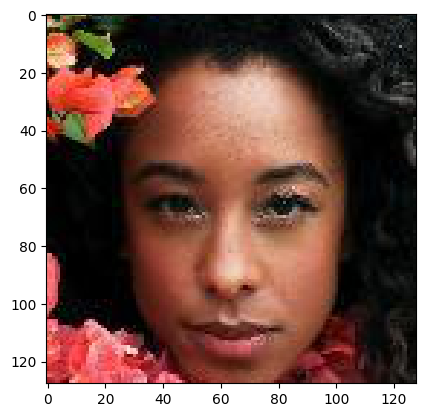

In [9]:
celeba_dataset.plot_image(43)

In [10]:
len(celeba_dataset)

20000

## 판별자 네트워크

- LeakyReLU 대신 GELU를 쓰면 성능이 소폭 향상된다

In [11]:
class Discriminator(nn.Module):

    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            # expect input of shape (1,3,128,128)
            nn.Conv2d(3, 256, kernel_size=8, stride=2),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 256, kernel_size=8, stride=2),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 3, kernel_size=8, stride=2),
            nn.LeakyReLU(0.2),

            View(3*10*10),
            nn.Linear(3*10*10, 1),
            nn.Sigmoid()
        )

        self.loss_function = nn.BCELoss()

        self.optimiser = torch.optim.Adam(self.parameters(), lr = 0.0001)

        self.counter = 0
        self.progress =[]

    def forward(self,inputs):
        return self.model(inputs)


    def train(self, inputs, targets):

        outputs = self.model(inputs)

        loss = self.loss_function(outputs, targets)

        self.counter += 1;
        if self.counter%10 == 0 :
            self.progress.append(loss.item())

        if (self.counter%1000==0):
            print('counter = ', self.counter)


        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()


    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
        pass


판별자 테스트

In [12]:
%%time
# test discriminator can separate real data from random noise

D = Discriminator()
# move model to cuda device
D.to(device)

for image_data_tensor in celeba_dataset:
    # real data
    D.train(image_data_tensor, torch.cuda.FloatTensor([1.0]))
    # fake data
    D.train(generate_random_image((1,3,128,128)), torch.cuda.FloatTensor([0.0]))



counter =  1000
counter =  2000
counter =  3000
counter =  4000
counter =  5000
counter =  6000
counter =  7000
counter =  8000
counter =  9000
counter =  10000
counter =  11000
counter =  12000
counter =  13000
counter =  14000
counter =  15000
counter =  16000
counter =  17000
counter =  18000
counter =  19000
counter =  20000
counter =  21000
counter =  22000
counter =  23000
counter =  24000
counter =  25000
counter =  26000
counter =  27000
counter =  28000
counter =  29000
counter =  30000
counter =  31000
counter =  32000
counter =  33000
counter =  34000
counter =  35000
counter =  36000
counter =  37000
counter =  38000
counter =  39000
counter =  40000
CPU times: user 6min 47s, sys: 6.25 s, total: 6min 53s
Wall time: 7min 45s


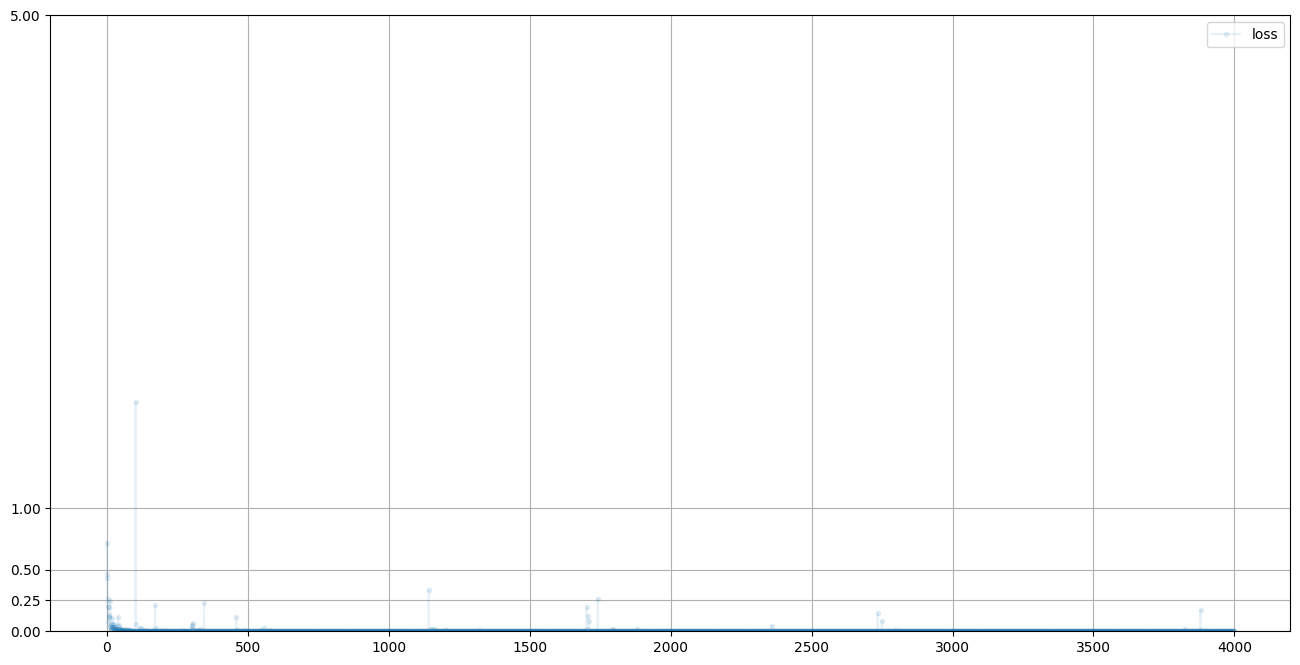

In [13]:
D.plot_progress()

In [14]:
for i in range(4):
  image_data_tensor = celeba_dataset[random.randint(0,20000)]
  print( D.forward( image_data_tensor ).item() )
  pass

for i in range(4):
  print( D.forward( generate_random_image((1,3,128,128))).item() )
  pass

1.0
1.0
1.0
1.0
1.5503186432397342e-06
1.1167437605763553e-06
1.5902151062618941e-06
1.325428547716001e-05


## 생성자 네트워크

In [15]:
class Generator(nn.Module):

    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            # input is a 1d array
            nn.Linear(100, 3*11*11),
            nn.LeakyReLU(0.2),

            # reshape to 4d
            View((1, 3, 11, 11)),

            #transposed CNN (cnn 뒤집기)
            nn.ConvTranspose2d(3, 256, kernel_size=8, stride=2),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(256, 256, kernel_size=8, stride=2),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(256, 3, kernel_size=8, stride=2, padding=1),
            nn.BatchNorm2d(3),

            # output should be (1,3,128,128)
            nn.Sigmoid()
        )

        self.optimiser = torch.optim.Adam(self.parameters(), lr = 0.0001)

        self.counter = 0
        self.progress =[]

        pass

    def forward(self,inputs):
        return self.model(inputs)

    def train(self, D, inputs, targets):
        #이미지 생성
        g_output = self.forward(inputs)

        #생성한 값을 판별
        d_output = D.forward(g_output)

        #판별한 값과 loss계산
        loss = D.loss_function(d_output, targets)

        #로깅
        self.counter +=1;
        if self.counter%10==0:
            self.progress.append(loss.item())

            pass

        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass

    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
        pass

    pass

생성자 테스트

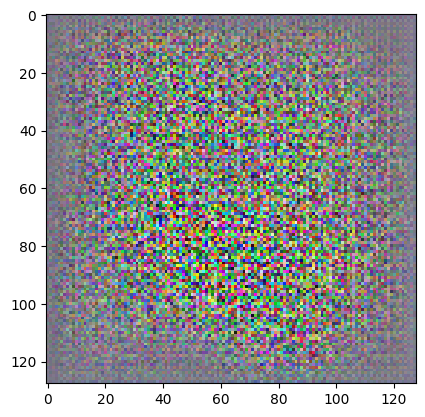

In [16]:
G = Generator()
# move model to cuda device
G.to(device)

output = G.forward(generate_random_seed(100))

img = output.detach().permute(0,2,3,1).view(128,128,3).cpu().numpy()

plt.imshow(img, interpolation='none', cmap='Blues')

## GAN 학습

In [17]:
%%time

# create Discriminator and Generator

D = Discriminator()
G = Generator()
D.to(device)
G.to(device)

epochs = 1

for epoch in range(epochs):
  print ("epoch = ", epoch + 1)

  # train Discriminator and Generator

  for image_data_tensor in celeba_dataset:
    # train discriminator on true
    D.train(image_data_tensor, torch.cuda.FloatTensor([1.0]))

    # train discriminator on false
    # use detach() so gradients in G are not calculated
    D.train(G.forward(generate_random_seed(100)).detach(), torch.cuda.FloatTensor([0.0]))

    # train generator
    G.train(D, generate_random_seed(100), torch.cuda.FloatTensor([1.0]))

    pass

  pass



epoch =  1
counter =  1000
counter =  2000
counter =  3000
counter =  4000
counter =  5000
counter =  6000
counter =  7000
counter =  8000
counter =  9000
counter =  10000
counter =  11000
counter =  12000
counter =  13000
counter =  14000
counter =  15000
counter =  16000
counter =  17000
counter =  18000
counter =  19000
counter =  20000
counter =  21000
counter =  22000
counter =  23000
counter =  24000
counter =  25000
counter =  26000
counter =  27000
counter =  28000
counter =  29000
counter =  30000
counter =  31000
counter =  32000
counter =  33000
counter =  34000
counter =  35000
counter =  36000
counter =  37000
counter =  38000
counter =  39000
counter =  40000
CPU times: user 13min 27s, sys: 5.85 s, total: 13min 33s
Wall time: 13min 50s


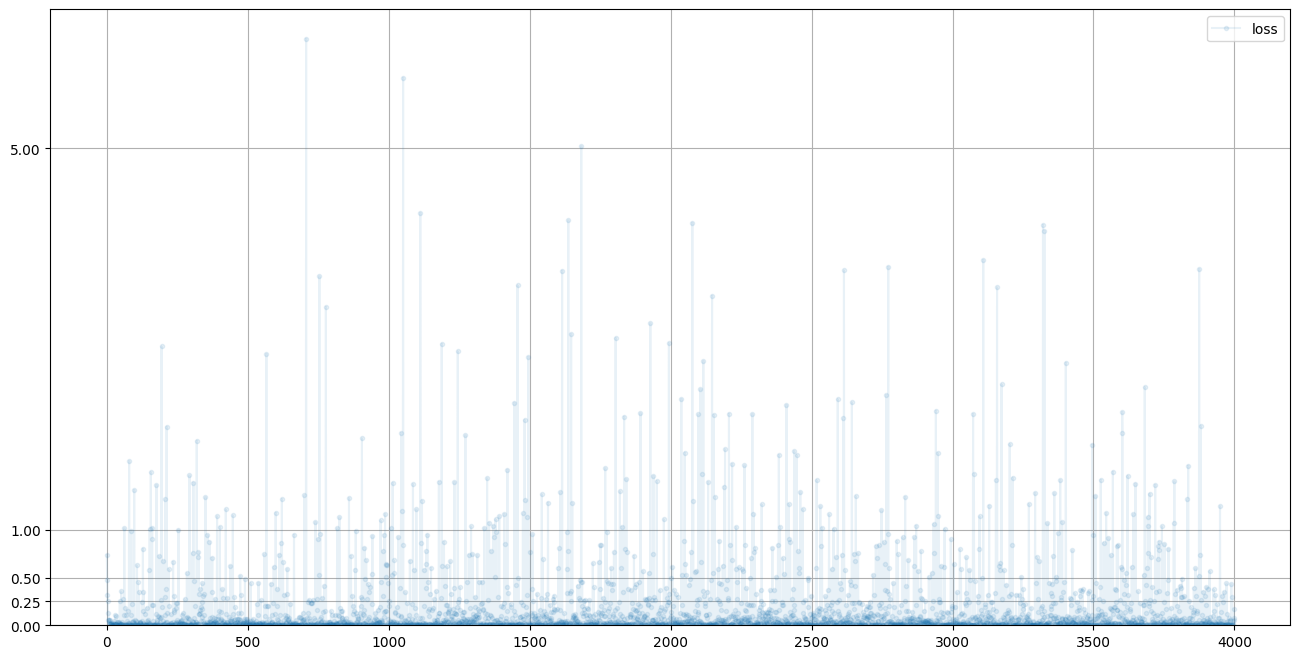

In [18]:
D.plot_progress()

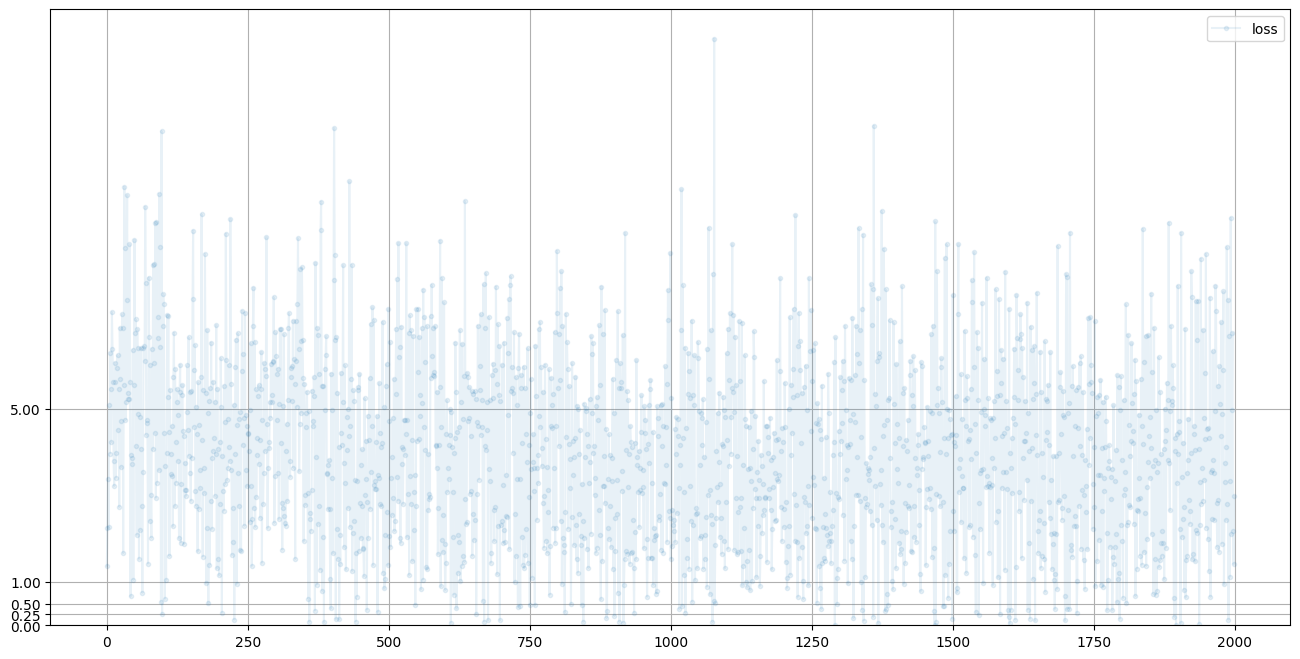

In [19]:
G.plot_progress()

## 학습한 모델로 이미지 생성

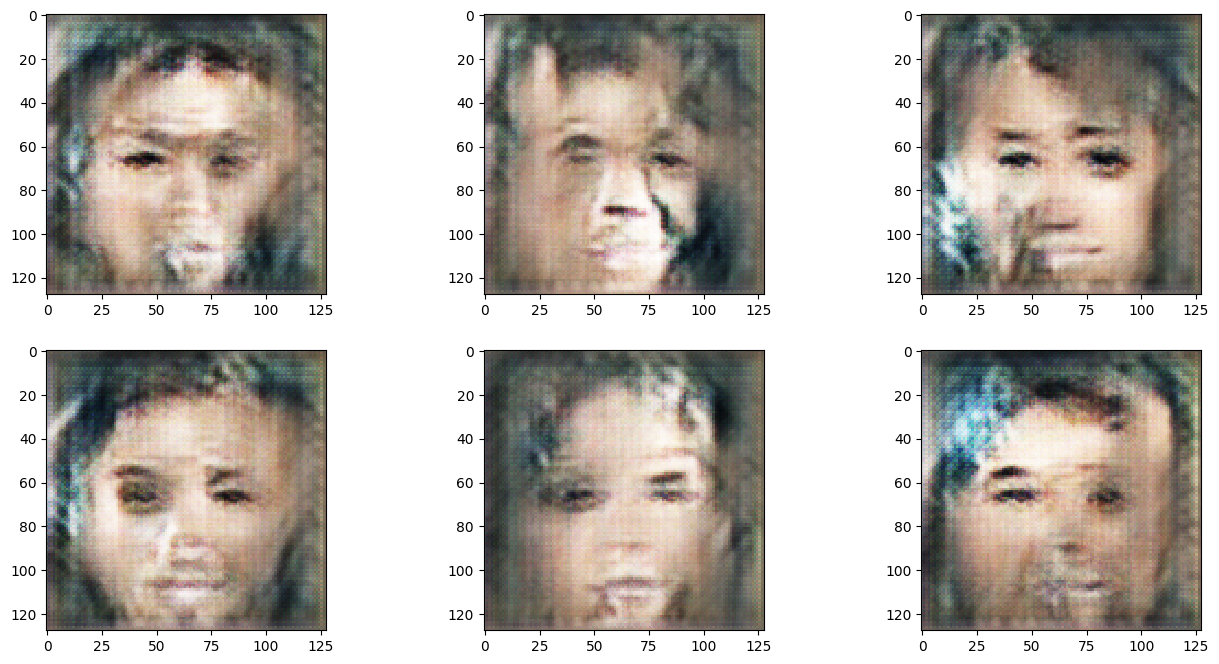

In [20]:
f, axarr = plt.subplots(2,3, figsize=(16,8))
for i in range(2):
    for j in range(3):
        output = G.forward(generate_random_seed(100))
        img = output.detach().permute(0,2,3,1).view(128,128,3).cpu().numpy()
        axarr[i,j].imshow(img, interpolation='none', cmap='Blues')
        pass
    pass

#Memory 사용 확인

In [21]:
# current memory allocated to tensors (in Gb)
# (1024*1024*1024)로 나누는 것은 바이트에서 기가로 바꾸는 작업

torch.cuda.memory_allocated(device) / (1024*1024*1024)

0.1601409912109375

* 0.97 기가바이트의 메모리가 텐서에 할당된 상태
* 이 메모리에는 판별자와 생정자 안의 데이터가 들어있음. 다시 사용될 여지가 있으므로 사라진 상태가 아님.

In [22]:
# total memory allocated to tensors during program (in Gb)
#실행중 도달한 최대 메모리 사용량

torch.cuda.max_memory_allocated(device) / (1024*1024*1024)

0.2486271858215332

In [23]:
# summary of memory consumption

print(torch.cuda.memory_summary(device, abbreviated=True))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      | 167920 KiB | 260704 KiB |  10444 GiB |  10444 GiB |
|---------------------------------------------------------------------------|
| Active memory         | 167920 KiB | 260704 KiB |  10444 GiB |  10444 GiB |
|---------------------------------------------------------------------------|
| Requested memory      | 165885 KiB | 259298 KiB |  10443 GiB |  10443 GiB |
|---------------------------------------------------------------

이 수치들을 통해 함수를 개량하면 메모리가 얼마나 줄어드는지 확인할 수 있다.


<font color='red'><b>**핵심 정리**</b></font>

- CNN기반의 분류 모델은 로컬한 정보를 통해 이미지 특성을 찾는다
- 합성곱은 커널을 활용해 특성맵을 산출한다
- 합성곱 레이어는 주어진 태스크에 대하여 좋은 커널을 학습한다. 어떠한 이미지 특성이 제일 쓸모있는지를 학습하는 것이다.
- 데이터를 줄이는 합성곱의 반대역할은 전치 합성곱, 생성적 네트워크를 만들기에 이상적이다.
- CNN은 FCN보다 더 적은 메모리를 사용한다
- CNN based GAN의 단점은 예를 들어 얼굴과 눈이 따로 노는 등 얼굴 요소들끼리 조화가 꺠질수 있다는 점 -> 지역적인 정보만 학습했기 때문에 전체적인 관계는 학습하지 못했음